# Real-world example: load netCDF data and calculate trends
introduce the use of the netCDF4 package and apply python, numpy and matplotlib knowledge from the basic session

In [1]:
%reset -f
import numpy as np
import netCDF4 as  netcdf
import matplotlib.pyplot as plt
%matplotlib inline

### preparation of dataset

In [2]:
# open netCDF dataset
ncid = netcdf.Dataset('./data/INSPIRE_1979_2016_monthly_oce_SST.nc')

# example: load a specific variable from the netCDF dataset
print(ncid.variables.keys())
lon = ncid.variables['longitude_ts'][:]

# more useful: choose to load every variable into an empty dictionary
data = {} 
for key in ncid.variables.keys():
    data[key] = ncid.variables[key][:]
    
# convert time variable into a more useful datatype
print(); print(ncid.variables['time'])
data['date'] = netcdf.num2date(data['time'],units=ncid.variables['time'].units,calendar=ncid.variables['time'].calendar)
    
# close netCDF dataset
ncid.close()

# lists entries in data dictionary
print(data.keys())

# this would fail as the dataset is already closed
# lat = ncid.variables['latitude_ts'][:]

odict_keys(['longitude_ts', 'latitude_ts', 'depth', 'time', 'SST'])

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    units: days since 1978-12-31 12:00:00
    calendar: standard
unlimited dimensions: time
current shape = (456,)
filling on, default _FillValue of 9.969209968386869e+36 used

dict_keys(['longitude_ts', 'latitude_ts', 'depth', 'time', 'SST', 'date'])


In [3]:
# getting an overview, print namespace with minimal formatting
%whos

Variable   Type       Data/Info
-------------------------------
data       dict       n=6
key        str        SST
lon        ndarray    586: 586 elems, type `float32`, 2344 bytes
ncid       Dataset    <object with id 140600509995272 (str() failed)>
netcdf     module     <module 'netCDF4' from '/<...>ges/netCDF4/__init__.py'>
np         module     <module 'numpy' from '/ho<...>kages/numpy/__init__.py'>
plt        module     <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>


In [4]:
# to-do: automatize this using glob with "intelligent" way to check for consistency with already existing meta-data

ncid = netcdf.Dataset('./data/INSPIRE_1979_2016_monthly_oce_SSS.nc')
data['SSS'] = ncid.variables['SSS'][:]
ncid.close()

ncid = netcdf.Dataset('./data/INSPIRE_1979_2016_monthly_oce_BSALT.nc')
data['BSALT'] = ncid.variables['BSALT'][:]
ncid.close()

ncid = netcdf.Dataset('./data/INSPIRE_1979_2016_monthly_oce_BTEMP.nc')
data['BTEMP'] = ncid.variables['BTEMP'][:]
ncid.close()

In [5]:
# getting an overview of the data dictionary

for key in data.keys():
    print(key,data[key].shape)

longitude_ts (586,)
latitude_ts (538,)
depth (1,)
time (456,)
SST (456, 1, 538, 586)
date (456,)
SSS (456, 1, 538, 586)
BSALT (456, 538, 586)
BTEMP (456, 538, 586)


In [6]:
# optional

del data['depth'] # delete this non-needed entry in the dictionary

In [7]:
# cleaning up two of the arrays
# to-do: automatize this ...

print(data['SST'].shape)
data['SST']=data['SST'].squeeze() # remove single-dimensional entries from array
print(data['SST'].shape)

# remove single-dimensional entries from the other array
data['SSS']=data['SSS'].squeeze()

(456, 1, 538, 586)
(456, 538, 586)


In [8]:
for key in data.keys():
    print(key,data[key].shape)

longitude_ts (586,)
latitude_ts (538,)
time (456,)
SST (456, 538, 586)
date (456,)
SSS (456, 538, 586)
BSALT (456, 538, 586)
BTEMP (456, 538, 586)


In [9]:
# optional, just because we are lazy typers ...

# rename an entry in two lines
data['lon'] = data['longitude_ts'] # assign object to a new reference
del data['longitude_ts'] # delete original reference

# rename an entry in one line
data['lat'] = data.pop('latitude_ts')

for key in data.keys():
    print(key,data[key].shape)

time (456,)
SST (456, 538, 586)
date (456,)
SSS (456, 538, 586)
BSALT (456, 538, 586)
BTEMP (456, 538, 586)
lon (586,)
lat (538,)


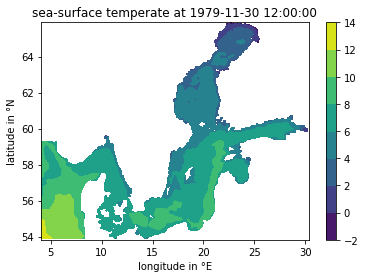

In [10]:
# first glance at snapshot of data e.g. sea-surface temperature

ti=10 # arbitrary temporal index

plt.figure()
plt.contourf(data['lon'],data['lat'],data['SST'][ti,:,:]); plt.colorbar()
plt.xlabel('longitude in °E'); plt.ylabel('latitude in °N')
plt.title('sea-surface temperate at '+str(data['date'][ti]))

# problem: want to calculate Baltic Sea temperature and salinity series
#   but North Sea would be used in array-wide calculations
# solution: mask out North Sea in dictionary

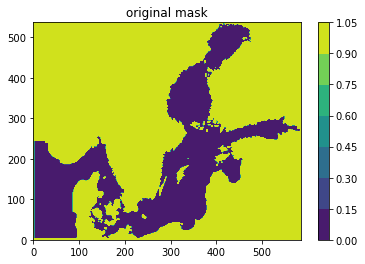

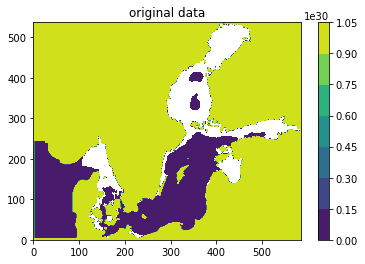

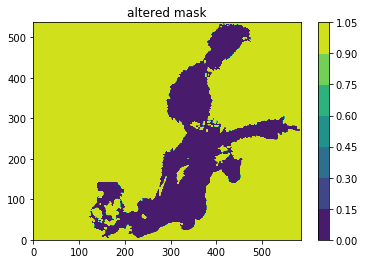

In [11]:
# mask out North Sea and Skaggerak/Kattegat
# i.e. data in the array are not touched

plt.figure(); plt.contourf(data['SST'][0,:,:].mask); plt.colorbar(); plt.title('original mask')
plt.figure(); plt.contourf(data['SST'][0,:,:].data); plt.colorbar(); plt.title('original data')

data['SST'][:,0:250,0:100].mask=True
data['SST'][:,145:275,100:200].mask=True
                                                                               
plt.figure(); plt.contourf(data['SST'][0,:,:].mask); plt.colorbar(); plt.title('altered mask')

# repeat masking for the other 3D variables
for key in ['SSS','BSALT','BTEMP']:
    data[key][:,0:250,0:100].mask=True
    data[key][:,145:275,100:200].mask=True

### doing some statistics

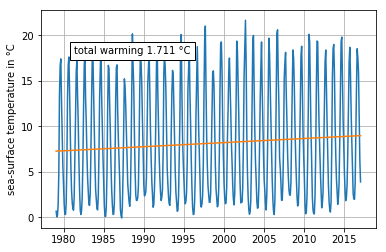

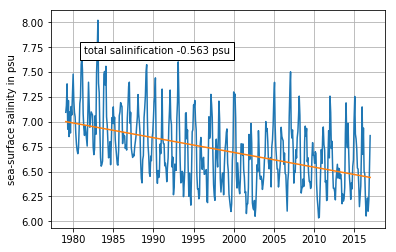

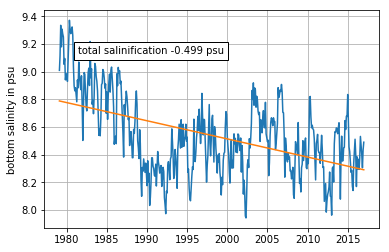

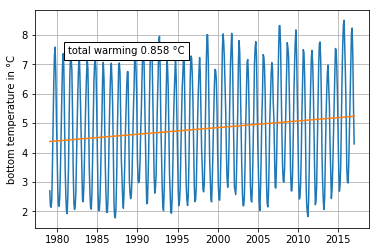

In [12]:
def fanalyze(fno,time,data,date,ylab,stext):
    zm2ean = np.nanmean(data,axis=(1,2)) 
    z = np.polyfit(time,zm2ean,1); #print(z)
    plt.figure(fno); ax1=plt.subplot(111)
    plt.plot(date,zm2ean)
    plt.plot(date,z[0]*time+z[1])
    plt.ylabel(ylab); plt.grid()
    plt.text(0.1,0.8,stext.format(z[0]*time[-1]),transform=ax1.transAxes,bbox=dict(facecolor='white'))
    
fanalyze(1,data['time'],data['SST'],data['date'],'sea-surface temperature in °C','total warming {0:.3f} °C')
fanalyze(2,data['time'],data['SSS'],data['date'],'sea-surface salinity in psu','total salinification {0:.3f} psu')
fanalyze(3,data['time'],data['BSALT'],data['date'],'bottom salinity in psu','total salinification {0:.3f} psu')
fanalyze(4,data['time'],data['BTEMP'],data['date'],'bottom temperature in °C','total warming {0:.3f} °C')

(538, 586) (456, 538, 586) (456, 538, 586)
size in Mb:  143.762208
size in Mb:  575.048832


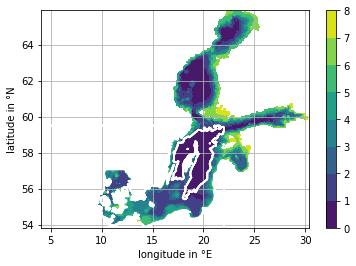

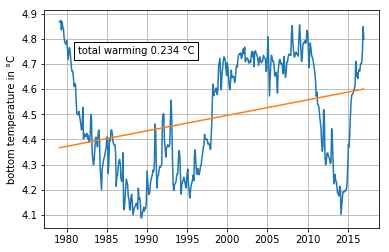

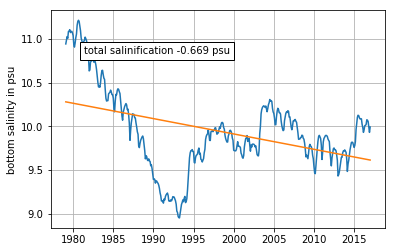

In [13]:
# getting a little bit more complex ... ?
# time series only for deeper layers of the Gotland Basin
# not changing the mask in the corresponding numpy array

# as we have no depth information,
# but knowing that deeper layers have less variability ...

mask2d = np.std(data['BTEMP'],axis=0).data < 0.80 

# limit values to the Gotland Basin ...

mask2d = mask2d*(data['lat'][:,np.newaxis] < 59.5)
mask2d = mask2d*(data['lon'][np.newaxis,:] < 22.0)

# just for checking which locations are taken ...

plt.figure() 
plt.contourf(data['lon'],data['lat'],np.std(data['BTEMP'],axis=0)); plt.colorbar()
plt.contour(data['lon'],data['lat'],mask2d,colors='w');
plt.ylabel('latitude in °N'); plt.xlabel('longitude in °E')
plt.grid()

# make 3D mask from 2D mask

mask3d = np.broadcast_to(mask2d, data['BTEMP'].shape) # broadcast to 3D and store output
print(mask2d.shape, mask3d.shape,data['BTEMP'].shape)
print('size in Mb: ',mask3d.nbytes/1e6)

# make suitable for use in fanalyse(.)

mask3d = mask3d.astype('float32') # np.nan is a float object and cannot be used with the integer datatype
mask3d[mask3d==0] = np.nan
print('size in Mb: ',mask3d.nbytes/1e6)

fanalyze(5,data['time'],data['BTEMP']*mask3d,data['date'],'bottom temperature in °C','total warming {0:.3f} °C')
fanalyze(3,data['time'],data['BSALT']*mask3d,data['date'],'bottom salinity in psu','total salinification {0:.3f} psu')

In [14]:
%whos

Variable   Type        Data/Info
--------------------------------
data       dict        n=8
fanalyze   function    <function fanalyze at 0x7fe00f6adc80>
key        str         BTEMP
lon        ndarray     586: 586 elems, type `float32`, 2344 bytes
mask2d     ndarray     538x586: 315268 elems, type `bool`, 315268 bytes (307.87890625 kb)
mask3d     ndarray     456x538x586: 143762208 elems, type `float32`, 575048832 bytes (548.4093017578125 Mb)
ncid       Dataset     <object with id 140600509994952 (str() failed)>
netcdf     module      <module 'netCDF4' from '/<...>ges/netCDF4/__init__.py'>
np         module      <module 'numpy' from '/ho<...>kages/numpy/__init__.py'>
plt        module      <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
ti         int         10


In [15]:
# simple scipy-statistics here? polyfit does not provide p-values etc.